In [26]:
import numpy as np
import pandas as pd
import os
from scipy import stats
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import dowhy
from dowhy import CausalModel
from sklearn.decomposition import PCA

In [28]:
effect_size_threshold = 0.5
correlation_threshold = 0.7  

def load_dataset(filename):
    try:
        return np.loadtxt(filename)
    except Exception as e:
        print(f"Error loading {filename}: {e}")
        return np.array([])

def load_all_datasets(base_path):
    datasets = {}
    for i in range(22):  
        train_file = os.path.join(base_path, f'd{i:02d}.dat')
        test_file = os.path.join(base_path, f'd{i:02d}_te.dat')
        
        if os.path.exists(train_file) and os.path.exists(test_file):
            train_data = load_dataset(train_file)
            test_data = load_dataset(test_file)
            if train_data.size == 0 or test_data.size == 0:
                continue
            combined_data = np.vstack((train_data, test_data))
            datasets[f'fault_{i:02d}'] = combined_data
    
    return datasets

def standardize_data(data):
    scaler = StandardScaler()
    return scaler.fit_transform(data)

In [30]:
def analyze_faults(datasets, effect_size_threshold=0.5):
    results = []
    normal_data = standardize_data(datasets['fault_00'])
    
    for fault, data in datasets.items():
        if fault == 'fault_00':
            continue
        
        print(f"Analyzing {fault}...")
        data = standardize_data(data)
        for var in range(data.shape[1]):
            t_stat, p_value = stats.ttest_ind(normal_data[:, var], data[:, var])
            effect_size = (np.mean(data[:, var]) - np.mean(normal_data[:, var])) / np.std(normal_data[:, var])
            if abs(effect_size) >= effect_size_threshold:
                results.append({
                    'Fault': fault,
                    'Variable': f'x{var}',
                    't_statistic': t_stat,
                    'p_value': p_value,
                    'effect_size': effect_size
                })
    
    return pd.DataFrame(results)

def analyze_variable_relationships(datasets, correlation_threshold=0.7):
    results = []
    
    for fault, data in datasets.items():
        if fault == 'fault_00':
            continue
        
        print(f"Analyzing variable relationships in {fault}...")
        data = standardize_data(data)
        num_vars = data.shape[1]
        for var1 in range(num_vars):
            for var2 in range(var1 + 1, num_vars):
                corr, _ = stats.pearsonr(data[:, var1], data[:, var2])
                if abs(corr) >= correlation_threshold:
                    results.append({
                        'Fault': fault,
                        'Variable1': f'x{var1}',
                        'Variable2': f'x{var2}',
                        'correlation': corr
                    })
    
    return pd.DataFrame(results)

In [32]:
def fit_dowhy_model(data, treatment, outcome, graph, method='backdoor'):
    model = CausalModel(
        data=data,
        treatment=treatment,
        outcome=outcome,
        graph=graph
    )
    identified_model = model.identify_effect(method_name=method)
    causal_effect = model.estimate_effect(identified_model)
    return model, identified_model, causal_effect

def plot_dag(G, title):
    pos = nx.spring_layout(G, seed=42)
    plt.figure(figsize=(12, 8))
    nx.draw(G, pos, with_labels=True, node_size=3000, node_color='lightblue', font_size=10, font_weight='bold', edge_color='gray', width=1.0, alpha=0.6)
    edge_labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
    plt.title(title)
    plt.show()

Analyzing fault_01...
Analyzing fault_02...
Analyzing fault_03...
Analyzing fault_04...
Analyzing fault_05...
Analyzing fault_06...
Analyzing fault_07...
Analyzing fault_08...
Analyzing fault_09...
Analyzing fault_10...
Analyzing fault_11...
Analyzing fault_12...
Analyzing fault_13...
Analyzing fault_14...
Analyzing fault_15...
Analyzing fault_16...
Analyzing fault_17...
Analyzing fault_18...
Analyzing fault_19...
Analyzing fault_20...
Analyzing fault_21...
No significant fault-variable relationships found.
Analyzing variable relationships in fault_01...
Analyzing variable relationships in fault_02...
Analyzing variable relationships in fault_03...
Analyzing variable relationships in fault_04...
Analyzing variable relationships in fault_05...
Analyzing variable relationships in fault_06...
Analyzing variable relationships in fault_07...
Analyzing variable relationships in fault_08...
Analyzing variable relationships in fault_09...
Analyzing variable relationships in fault_10...
Analyzi

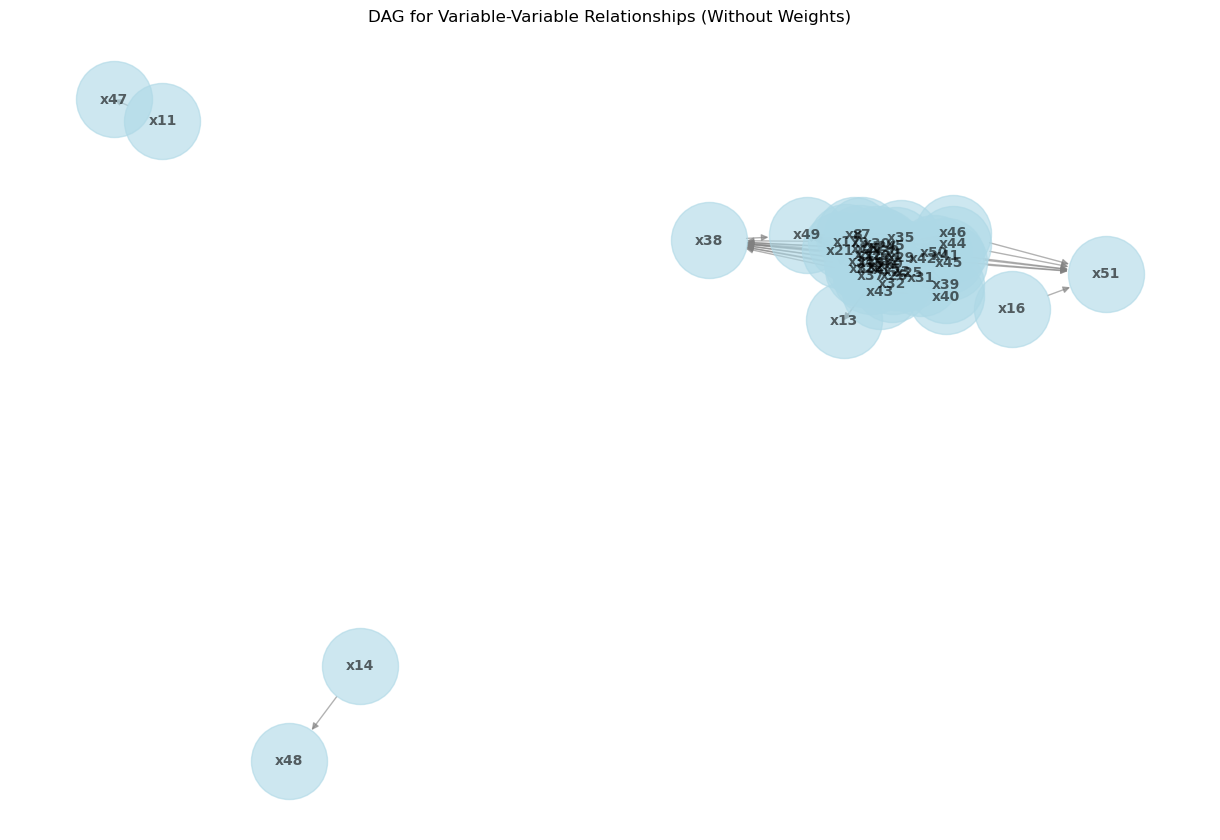

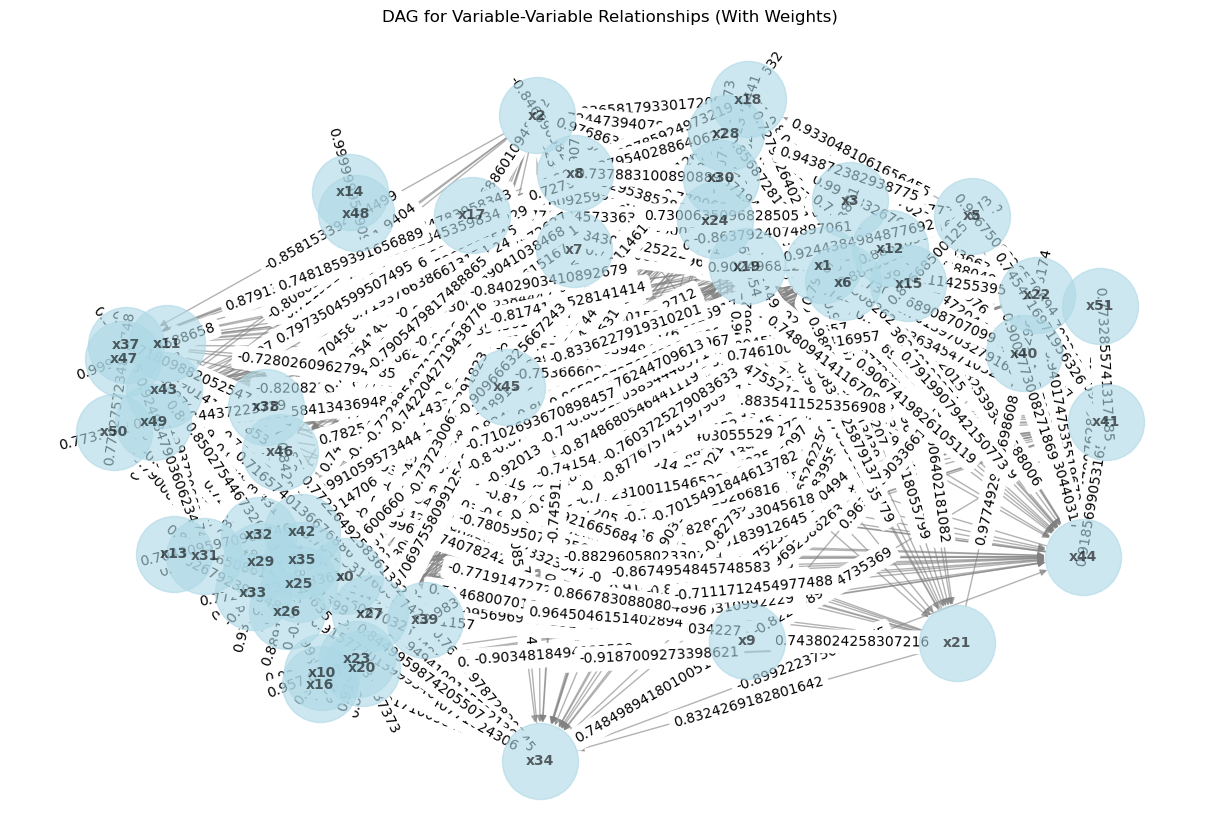

In [34]:
base_path = 'tennessee-eastmen-process-classification/TE_process/data/'
datasets = load_all_datasets(base_path)

results_df = analyze_faults(datasets, effect_size_threshold)

if results_df.empty:
    print("No significant fault-variable relationships found.")
else:
    results_df['abs_effect_size'] = np.abs(results_df['effect_size'])
    sorted_results = results_df.sort_values('abs_effect_size', ascending=False)

    print("\nTop 20 strongest fault-variable relationships:")
    print(sorted_results[['Fault', 'Variable', 'effect_size', 'p_value']].head(20))

    print("\nSummary Statistics:")
    summary = results_df.groupby('Fault')['effect_size'].agg(['mean', 'std', 'min', 'max'])
    print(summary)

    pivot_df = results_df.pivot(index='Fault', columns='Variable', values='effect_size')
    plt.figure(figsize=(20, 10))
    sns.heatmap(pivot_df, cmap='coolwarm', center=0, annot=True, fmt='.2f')
    plt.title('Effect Size Heatmap: Faults vs Variables')
    plt.tight_layout()
    plt.show()

    for fault in [f'fault_{i:02d}' for i in range(1, 22)]:
        data = pd.DataFrame(datasets[fault], columns=[f'x{i}' for i in range(datasets[fault].shape[1])])
        treatment = 'Fault'
        outcome = 'Variable'
        graph = f"""
        digraph {{
            Fault -> Variable;
        }}
        """
        model, identified_model, causal_effect = fit_dowhy_model(data, treatment, outcome, graph)
        print(f"\nCausal Effect for {fault}:")
        print(causal_effect)

    G = nx.DiGraph()
    for _, row in results_df.iterrows():
        G.add_edge(row['Fault'], row['Variable'])
    plot_dag(G, 'DAG for Fault-Variable Relationships (Without Weights)')
    
    G = nx.DiGraph()
    for _, row in results_df.iterrows():
        G.add_edge(row['Fault'], row['Variable'], weight=row['effect_size'])
    plot_dag(G, 'DAG for Fault-Variable Relationships (With Weights)')

var_results_df = analyze_variable_relationships(datasets, correlation_threshold)

if var_results_df.empty:
    print("No significant variable-variable relationships found.")
else:
    G = nx.DiGraph()
    for _, row in var_results_df.iterrows():
        G.add_edge(row['Variable1'], row['Variable2'])
    plot_dag(G, 'DAG for Variable-Variable Relationships (Without Weights)')
    
    G = nx.DiGraph()
    for _, row in var_results_df.iterrows():
        G.add_edge(row['Variable1'], row['Variable2'], weight=row['correlation'])
    plot_dag(G, 'DAG for Variable-Variable Relationships (With Weights)')
